# <center><b> Modelo de Regresión Lineal </b></center>

## **Librerías**

In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import pingouin as pg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_harvey_collier, het_breuschpagan
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error
from math import pi
from yellowbrick.regressor import ResidualsPlot

## **Funciones**

In [209]:
def plot_hist(df, variables, bins=50, n_cols=3, figsize=(16,10)):
    n_vars = len(variables)
    n_rows = int(np.ceil(n_vars / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for i, var in enumerate(variables):
        ax = axes[i]
        data = df[var].dropna()
        n, bins_edges, patches = ax.hist(
            data, bins=bins, facecolor='#2ab0ff', 
            edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
        n = n.astype(int)
        for j in range(len(patches)):
            patches[j].set_facecolor(plt.cm.viridis(n[j]/max(n)))
        mean_val = data.mean()
        median_val = data.median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f"Media: {mean_val:.2f}")
        ax.axvline(median_val, color='green', linestyle='-', linewidth=1.5, label=f"Mediana: {median_val:.2f}")
        ax.set_title(var, fontsize=12)
        ax.set_xlabel("Valor", fontsize=10)
        ax.set_ylabel("Frecuencia", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(1.2)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

def detect_outliers_summary(data, n_cols=3, threshold=3, figsize=(15, 10)):
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    results = []
    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_iqr = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        mean = data[col].mean()
        std = data[col].std()
        z_scores = (data[col] - mean) / std
        outliers_z = data[np.abs(z_scores) > threshold]
        results.append({
            "Variable": col,
            "Outliers_IQR": len(outliers_iqr),
            "Outliers_ZScore": len(outliers_z)
        })
    outlier_summary = pd.DataFrame(results)
    n_vars = len(numeric_cols)
    n_rows = int(np.ceil(n_vars / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=data[col], color="skyblue", ax=axes[i])
        axes[i].set_title(f"Boxplot de {col}")
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()
    return outlier_summary

def adjusted_r2(y_true, y_pred, n_features):
    n = len(y_true)
    r2 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
    adj_r2 = 1 - (1 - r2) * (n - 1)/(n - n_features - 1)
    return adj_r2

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mbd(y_true, y_pred):
    return np.mean((y_pred - y_true)/y_true) * 100

def concordance_correlation(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cov = np.mean((y_true - mean_true)*(y_pred - mean_pred))
    ccc = (2 * cov) / (var_true + var_pred + (mean_true - mean_pred)**2)
    return ccc

def cv_rmse(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    return rmse / np.mean(y_true) * 100

def index_of_agreement(y_true, y_pred):
    mean_true = np.mean(y_true)
    numerator = np.sum((y_pred - y_true)**2)
    denominator = np.sum((np.abs(y_pred - mean_true) + np.abs(y_true - mean_true))**2)
    d = 1 - numerator/denominator
    return d

def picp(y_true, lower, upper):
    inside = np.logical_and(y_true >= lower, y_true <= upper)
    return np.mean(inside) * 100

def plot_residual_impact(X_test, y_test, y_pred, ncols=3, n_bins=20, figsize_per_subplot=(5,4)):
    residuals = y_test.values - y_pred
    n_vars = X_test.shape[1]
    nrows = int(np.ceil(n_vars / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize_per_subplot[0]*ncols, figsize_per_subplot[1]*nrows))
    axes = axes.flatten()
    for i, col in enumerate(X_test.columns):
        feature = X_test[col]
        bins = np.linspace(feature.min(), feature.max(), n_bins)
        digitized = np.digitize(feature, bins)
        bin_means = [residuals[digitized==j].mean() for j in range(1, len(bins))]
        ax = axes[i]
        ax.plot(bins[1:], bin_means, marker='o', linestyle='-', color='purple')
        ax.axhline(0, color='black', linestyle='--')
        ax.set_xlabel(f"Valor de {col}")
        ax.set_ylabel("Residual promedio")
        ax.set_title(f"Impacto de {col}")
    for k in range(n_vars, len(axes)):
        fig.delaxes(axes[k])
    plt.tight_layout()
    plt.show()

def standardized_residuals(residuals):
    std_resid = np.std(residuals, ddof=1)
    return residuals / std_resid

def studentized_residuals_approx(residuals):
    n = len(residuals)
    mse = np.sum(residuals**2) / (n - 2)
    stud_resid = residuals / np.sqrt(mse * (1 - 1/n))
    return stud_resid

## **Datos**

In [170]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/Advertising.csv"
df = pd.read_csv(url, index_col=0)
print(df.head())

      TV  radio  newspaper  sales
1  230.1   37.8       69.2   22.1
2   44.5   39.3       45.1   10.4
3   17.2   45.9       69.3    9.3
4  151.5   41.3       58.5   18.5
5  180.8   10.8       58.4   12.9


**Descripción de los datos - Advertising Dataset**

El dataset **Advertising** contiene información sobre el gasto en publicidad en tres medios (TV, Radio y Newspaper) y su relación con las ventas de un producto.

**Variables:**
- **TV**: Gasto en publicidad en televisión (en miles de dólares).
- **Radio**: Gasto en publicidad en radio (en miles de dólares).
- **Newspaper**: Gasto en publicidad en periódicos (en miles de dólares).
- **Sales**: Ventas del producto (en miles de unidades).

> Este dataset es ampliamente utilizado en **regresión lineal** para analizar cómo la inversión publicitaria en diferentes canales influye en las ventas.

## **Análisis Exploratorio de los Datos**

### Dimensiones

In [171]:
df.shape

(200, 4)

Esto deja en razón de 50 registros por variable, lo cual es aceptable para el modelo de regresión lineal siendo el requisito mínimo de 20 registros por variable.

### Tipos de Datos

In [172]:
df.dtypes

TV           float64
radio        float64
newspaper    float64
sales        float64
dtype: object

Todas las variables están en el formato correcto, por lo que se dejará como está.

### Valores Nulos

In [173]:
df.isna().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

No hay presencia de valores nulos, por lo que se obviaría este proceso en el preprocesamiento de datos.

### Descriptivos

In [174]:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [175]:
pd.DataFrame((df.describe().loc['std',]/np.abs(df.describe().loc['mean',])*100), columns = ['CV']).sort_values('CV', ascending=False).T

,newspaper,radio,TV,sales
CV,71.279115,63.818815,58.387362,37.207749


Al presentarse diferentes escalas de las variables se debería de escalar los datos, además de ello, el gasto de publicidad en periódicos es el más variante.

### Visualización

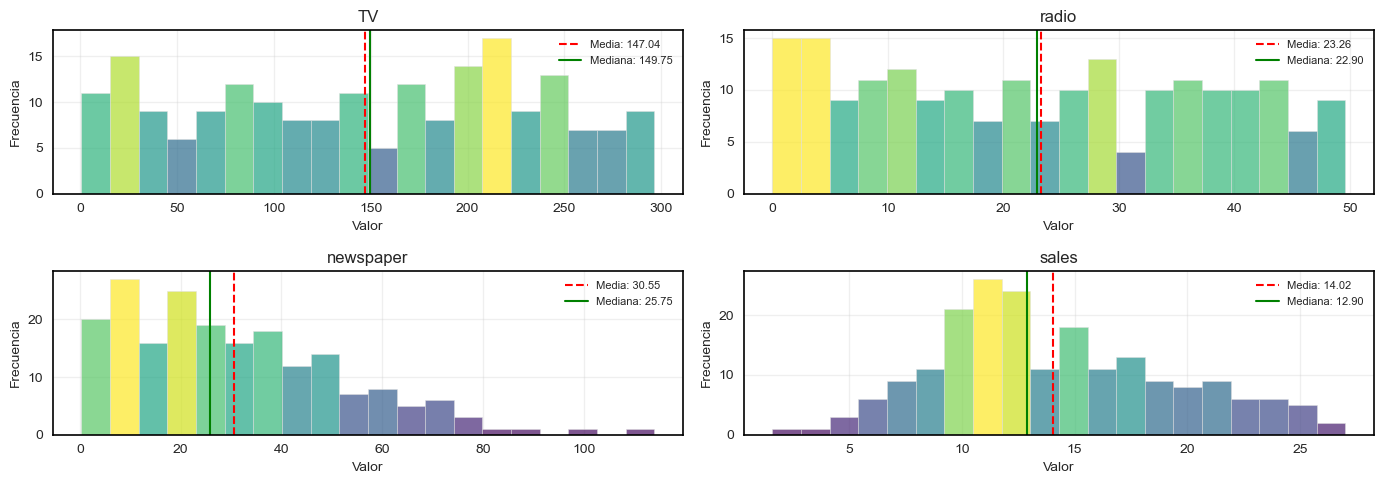

In [204]:
plot_hist(df, df.columns, bins=20, n_cols=2, figsize=(14,5))

De las distribuciones el gasto de publicidad en periódicos tiene asimetria positiva con cola a la derecha, mientras que el número de ventas tiene una distribución "normal", las otras variables dan la impresión de tener una distribución más uniforme.

### Pruebas de Hipótesis

#### Normalidad Univariada

In [177]:
for col in df.columns:
    stat, p = shapiro(df[col])
    print(f"{col}: W={stat:.4f}, p={p:.4f}")
    if p > 0.05:
        print("No se rechaza H0 (normal)")
    else:
        print("Se rechaza H0 (no normal)")

TV: W=0.9495, p=0.0000
Se rechaza H0 (no normal)
radio: W=0.9440, p=0.0000
Se rechaza H0 (no normal)
newspaper: W=0.9364, p=0.0000
Se rechaza H0 (no normal)
sales: W=0.9760, p=0.0017
Se rechaza H0 (no normal)


Dada la prueba de hipótesis de **Shapiro**, las variables no tiene distribución normal.

#### Normalidad Multivariada

In [178]:
hz = pg.multivariate_normality(df, alpha=0.05)
print(hz)

HZResults(hz=4.083571955671743, pval=1.594138238093308e-45, normal=False)


Las variables en conjunto no presentan una distribución normal multivariada.

### Correlaciones

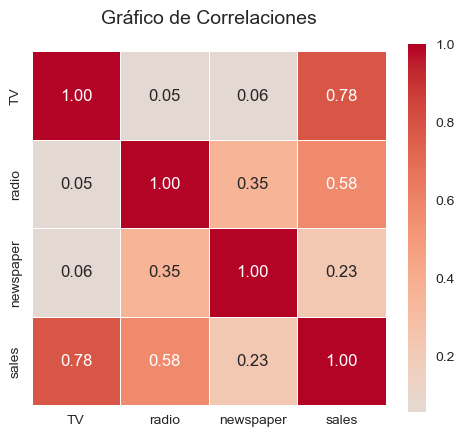

In [179]:
corr_matrix = df.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(
    corr_matrix, 
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0, 
    square=True,
    linewidths=.5, 
    cbar_kws={"shrink": .8}
)
plt.title("Gráfico de Correlaciones", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

No se aprecia multicoplinealidad alarmante en las variables aunque igual es mejor evaluarlo que dejarlo en una corazonada, por otro lado, la variable más correlacionada con las ventas es la publicidad dada por la televisión, seguida de radio y muy por debajo por el periódico.

### Outliers

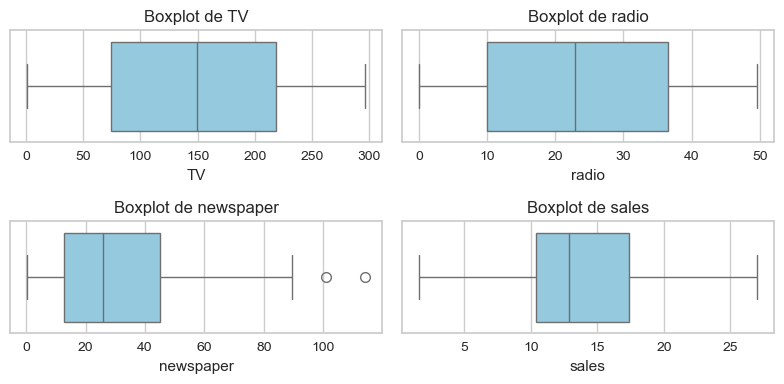

,Variable,Outliers_IQR,Outliers_ZScore
0,TV,0,0
1,radio,0,0
2,newspaper,2,2
3,sales,0,0


In [180]:
detect_outliers_summary(df, n_cols=2, threshold=3, figsize=(8, 4))

Según dos metodologías para determinar valores atípicos, solo se presentan dos observaciones que son muy diferentes en la variable de **newspaper**.

## **Preprocesamiento de Datos**

### Separación de Datos

In [181]:
X = df[["TV", "radio", "newspaper"]]
y = df["sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Se está separando los datos en 75% en train y 25% para la data test.

### Escalamiento de Datos

In [182]:
mms = MinMaxScaler().fit(X_train)

X_train_scaled = pd.DataFrame(mms.transform(X_train), columns = X.columns)
X_test_scaled = pd.DataFrame(mms.transform(X_test), columns = X.columns)

Al no comprobarse el supuesto de normalidad, se hará uso del escalada mínimo - máximo para homogenizar las escalas de las variables.

## **Modelado de los Datos**

### Primer Modelado

In [183]:
lr_mod = LinearRegression()
lr_mod.fit(X_train_scaled, y_train)

y_pred = lr_mod.predict(X_test_scaled)

Modelo ejecutado para el estudio de los supuestos necesarios del modelo.

### Evaluación de Supuestos

#### Normalidad

In [215]:
y_fitted = lr_mod.predict(X_train_scaled)
residuals = y_train - y_fitted
residuals = studentized_residuals_approx(residuals)

stat, p = shapiro(residuals)
print(f"Residuales: W={stat:.4f}, p={p:.4f}")

Residuales: W=0.9000, p=0.0000


Se **rechaza** el supuesto de normalidad en los residuales del modelo. 

#### Independencia

In [211]:
dw = durbin_watson(residuals)
print("Durbin-Watson:", dw)

Durbin-Watson: 2.152622408419965


El Estadístico de Durbin-Watson es muy cercano a 2, por lo que indicaría la independencia de los residuales.

#### Homocedasticidad

In [212]:
X_exog = np.hstack([np.ones((X_train_scaled.shape[0],1)), X_train_scaled])
bp_test = het_breuschpagan(residuals, X_exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 4.4493924482353115, 'LM-Test p-value': 0.21684902986599694, 'F-Statistic': 1.4877100328862658, 'F-Test p-value': 0.22034481173027573}


En mabas pruebas se determina que los residuales tienen homocedasticidad.

#### Linealidad

In [187]:
X_const = sm.add_constant(X_train_scaled)
model_sm = sm.OLS(y_train.values, X_const).fit()

hc_stat, hc_p = linear_harvey_collier(model_sm)
print("Harvey-Collier test statistic:", hc_stat)
print("p-value:", hc_p)

Harvey-Collier test statistic: 1.1361162666795839
p-value: 0.2577693517162741


Dada la prueba, las predicciones del modelo respecto a las demás variables son lineales.

#### Multicolinealidad

In [188]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]

print(vif_data)

     feature       VIF
0         TV  2.509336
1      radio  3.504872
2  newspaper  3.236891


Las variables tampoco presentan multicolinealidad alta por lo que no requiere técnicas para reducir este factor.

### Evaluación del Modelo

In [189]:
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     422.2
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           1.02e-71
Time:                        15:58:43   Log-Likelihood:                -289.20
No. Observations:                 150   AIC:                             586.4
Df Residuals:                     146   BIC:                             598.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8109      0.373      7.531      0.0

Aquí, se aprecia segun la prueba F que el modelo es significativo, el modelo explica el 89.7% de la variabilidad total, los coeficientes resultan significativos a excepción de la variable de **newspaper**, las pruebas de Omnibus y Jarque - Bera indican que los residuales no siguen una distribución normal, los residuales son independientes y Cond. No. indica que no hay multicolinealidad alarmante.

### Métricas de Evaluación

In [190]:
rmse = root_mean_squared_error(y_test, y_pred)
pred_lower = y_pred - 1.96*rmse
pred_upper = y_pred + 1.96*rmse
n_features = X_train.shape[1]

metrics = {
    "Adjusted R2": adjusted_r2(y_test, y_pred, n_features),
    "RMSLE": rmsle(y_test, y_pred),
    "sMAPE": smape(y_test, y_pred),
    "MBD": mbd(y_test, y_pred),
    "CCC": concordance_correlation(y_test, y_pred),
    "CV(RMSE)": cv_rmse(y_test, y_pred),
    "Index of Agreement": index_of_agreement(y_test, y_pred),
    "PICP (%)": picp(y_test, pred_lower, pred_upper)
}

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Adjusted R2: 0.8866
RMSLE: 0.1705
sMAPE: 13.9697
MBD: 0.9094
CCC: 0.9446
CV(RMSE): 12.8800
Index of Agreement: 0.9716
PICP (%): 96.0000


| Métrica | Qué evalúa | Mi interpretación (primera persona) | Valores favorables |
|---------|------------|-----------------------------------|-----------------|
| Adjusted R² | Proporción de variabilidad de "sales" explicada por mis predictores (TV, radio, newspaper), ajustada por el número de variables | Con un Adjusted R² de 0.8866, veo que **el 88.66% de la variación en las ventas está explicado por mi modelo**, lo cual me da mucha confianza en el ajuste. | Alto, cercano a 1 |
| RMSLE | Error cuadrático sobre logaritmos, útil para escalas distintas y crecimiento relativo | RMSLE = 0.1705 me indica que **el error relativo en predicciones logarítmicas es bajo**, lo que es bueno para los rangos de ventas que van de ~1 a ~27. | Bajo |
| sMAPE | Error porcentual simétrico promedio | Con sMAPE = 13.97%, puedo decir que **mis predicciones difieren en promedio un ~14% de los valores reales**, lo que considero aceptable para predicción de ventas. | Bajo |
| MBD | Sesgo promedio: indica si el modelo sobreestima o subestima sistemáticamente | MBD = 0.9094% me muestra que **mi modelo no tiene sesgo significativo**, apenas sobreestima las ventas en un 0.9%, casi neutro. | Cercano a 0 |
| CCC | Concordancia entre predicciones y observaciones, combina correlación y sesgo | CCC = 0.9446 me dice que **mis predicciones coinciden muy bien con los valores reales**, tanto en tendencia como en magnitud, excelente concordancia. | Alto, cercano a 1 |
| CV(RMSE) | RMSE relativo al promedio de "sales" | CV(RMSE) = 12.88% indica que **el error típico es solo ~13% del valor promedio de ventas**, lo que me da confianza en la precisión relativa del modelo. | Bajo |
| Index of Agreement | Precisión general del modelo, penaliza sobre- y subestimaciones | Index of Agreement = 0.9716 me muestra que **el modelo tiene excelente ajuste general**, con mínima discrepancia entre predicciones y valores reales. | Alto, cercano a 1 |
| PICP (%) | Cobertura de los valores reales dentro de un intervalo de predicción | PICP = 96% indica que **el 96% de las ventas reales caen dentro de mis intervalos de predicción ±1.96*RMSE**, lo que refleja predicciones confiables y robustas. | Alto, cercano a 100% |


### Visualización del Modelo

#### Dispersión y Distribución de Residuales

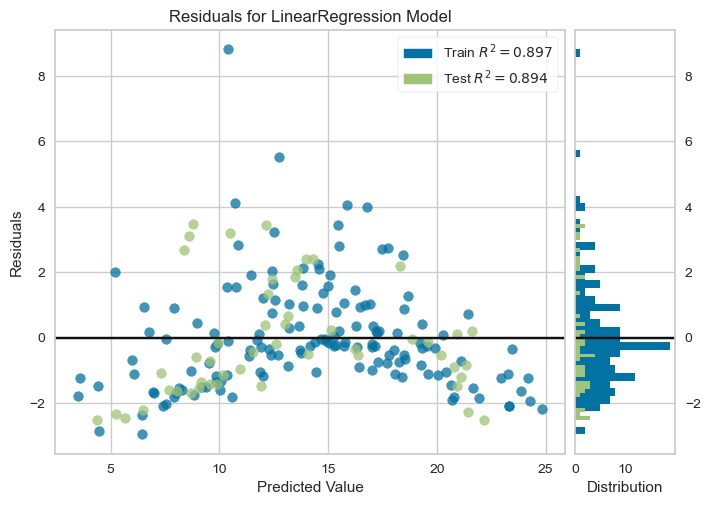

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [220]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_scaled, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show()

La mayoría de los residuales fluctuan en el valor de 0, lo cual es lo que se espera, sin embargo, hay errores muy grandes que puedan atribuirse a valores atípicos.

C:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


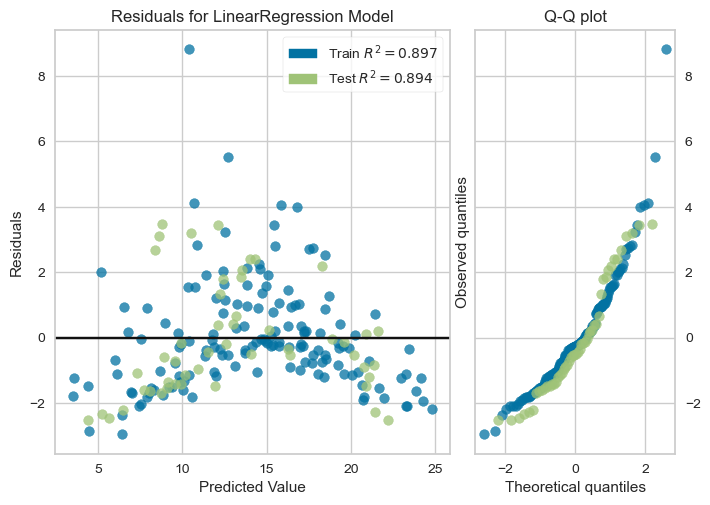

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [192]:
visualizer = ResidualsPlot(model, hist=False, qqplot=True)
visualizer.fit(X_train_scaled, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show()

Aquí se puede apreciar un poco que las distribuciones de los residuales no siguen una distribución normal, pues deben comportarse más como una recta pero se evidencia cierta curva en los valores.

#### Valores Influenciales

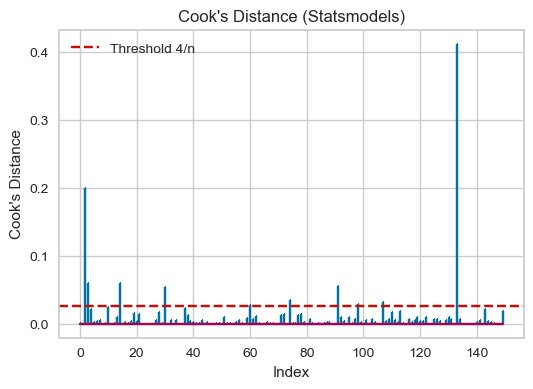

In [193]:
influence = model_sm.get_influence()
cooks_d, pvals = influence.cooks_distance

plt.figure(figsize=(6,4))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", linefmt="C0-")
plt.axhline(4/len(cooks_d), color='r', linestyle='--', label="Threshold 4/n")
plt.xlabel("Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance (Statsmodels)")
plt.legend()
plt.show()

Se visualizan al menos 7 observaciones que afectan al rendimiento del modelo, al ser pocas podría evaluarse retirarlas del estudio para mejorar la presición del modelo.

#### Distribución de los Redisuales con Contraste

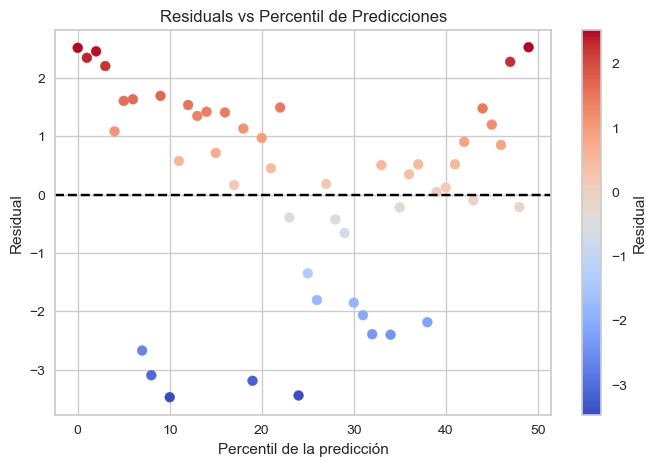

In [221]:
percentiles = np.arange(len(y_test))
sorted_idx = np.argsort(y_pred)
sorted_residuals = y_test.values[sorted_idx] - y_pred[sorted_idx]

plt.figure(figsize=(8,5))
plt.scatter(percentiles, sorted_residuals, c=sorted_residuals, cmap='coolwarm', s=50)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Percentil de la predicción")
plt.ylabel("Residual")
plt.title("Residuals vs Percentil de Predicciones")
plt.colorbar(label="Residual")
plt.show()


Este grafico muestra lo mismo que grafico anteriores pero deja ver un contraste de colores convenientes para determinar que valores están con un error más crítico.

#### Impacto de las Variables en los Residuales

C:\Users\David Torres\AppData\Local\Temp\ipykernel_26440\1731772452.py:114: RuntimeWarning: Mean of empty slice.
  bin_means = [residuals[digitized==j].mean() for j in range(1, len(bins))]
C:\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


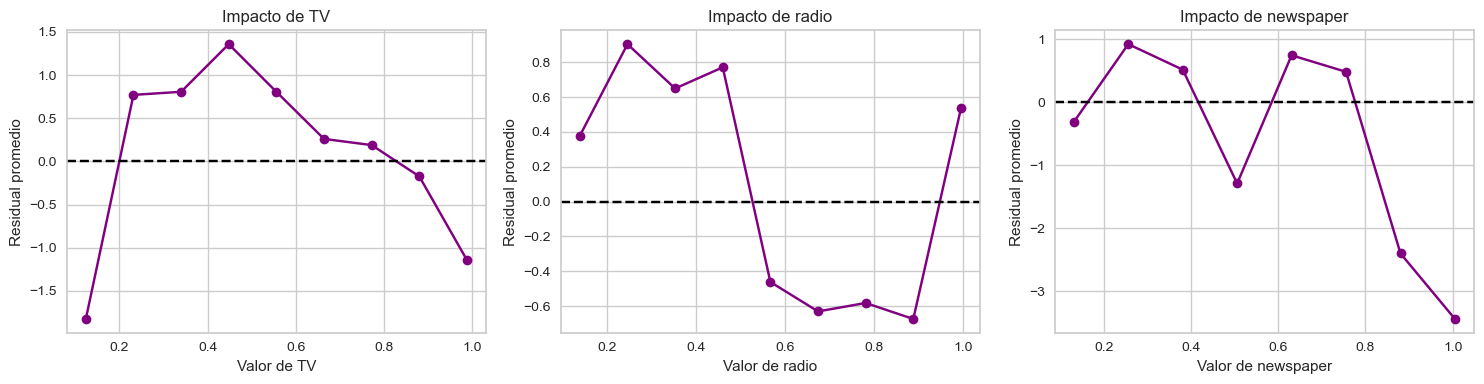

In [195]:
plot_residual_impact(X_test_scaled, y_test, y_pred, ncols=3, n_bins=10)

Gráfico que muestra la acumulación de los residuales por diferentes cortes en las variables que se usaron, la variable radio se mantiene con residuales pequeños a lo largo de su distribución, mientras que la variable **TV** presenta residuales más grandes en valores bajos de su distribución, finalmente **newspaper** presenta residuales más grandes en valores más altos de su distribución.

#### Residuales Acumulados

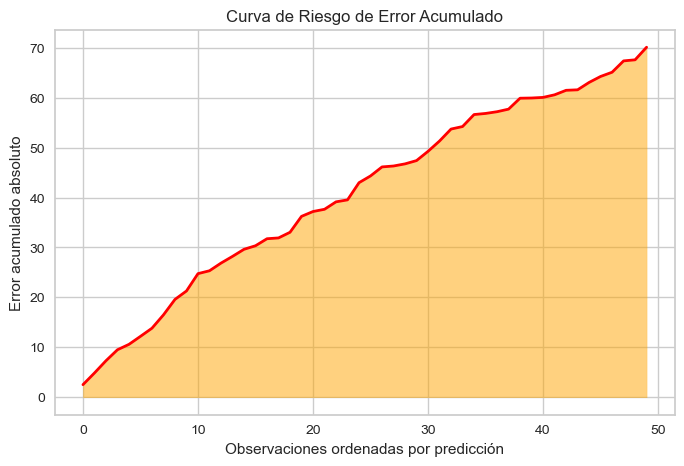

In [196]:
sorted_idx = np.argsort(y_pred)
sorted_residuals = np.abs(y_test.values[sorted_idx] - y_pred[sorted_idx])
cumulative_residuals = np.cumsum(sorted_residuals)

plt.figure(figsize=(8,5))
plt.fill_between(range(len(sorted_residuals)), cumulative_residuals, color='orange', alpha=0.5)
plt.plot(range(len(sorted_residuals)), cumulative_residuals, color='red', linewidth=2)
plt.xlabel("Observaciones ordenadas por predicción")
plt.ylabel("Error acumulado absoluto")
plt.title("Curva de Riesgo de Error Acumulado")
plt.show()

Grafico acumulativo de residuales, permite determinar saltos (patrones) en ciertos rangos de datos, en este caso el grafico da un escalamiento considerable, por lo que no hay un error sistemático en algunas secciones de los datos.

#### Importancia de Variables

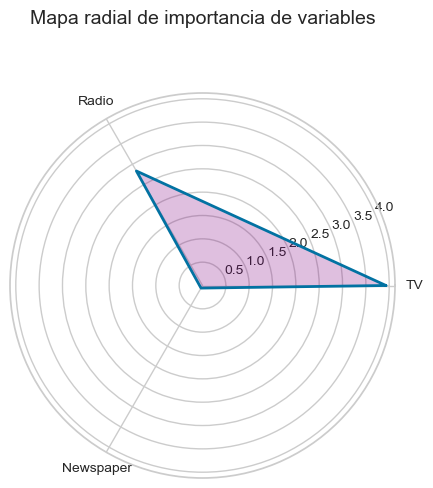

In [222]:
categories = ['TV', 'Radio', 'Newspaper']
N = len(categories)
coefs = lr_mod.coef_
stds = X_test_scaled.std(axis=0).values
values = np.abs(coefs * stds)
values = np.append(values, values[0])
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(polar=True))
ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, 'purple', alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title("Mapa radial de importancia de variables", size=14, pad=50) 
plt.show()

Gráfico que muestra la relevancia de las variables en el modelo.

#### Ajuste de las Predicciones

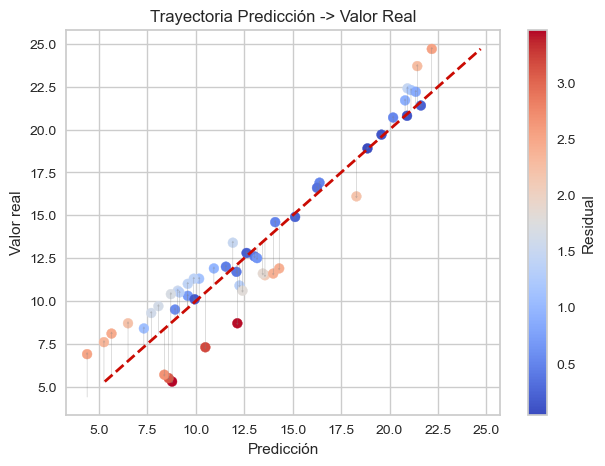

In [198]:
plt.figure(figsize=(7,5))
plt.scatter(y_pred, y_test, c=np.abs(y_test - y_pred), cmap="coolwarm", s=50)

for i in range(len(y_test)):
    plt.arrow(
        y_pred[i],              
        y_pred[i],               
        0,                      
        y_test.iloc[i] - y_pred[i],
        head_width=0.1,
        head_length=0.1,
        color='gray',
        alpha=0.3
    )

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Trayectoria Predicción -> Valor Real")
plt.colorbar(label="Residual")
plt.show()

Se aprecia que se tienen algunos datos con valores atipicos a la recta regresora, se podría evaluar quitarlos para tener más presicion en el modelo.

#### Distribución de los Rediduales por Areas de Corte

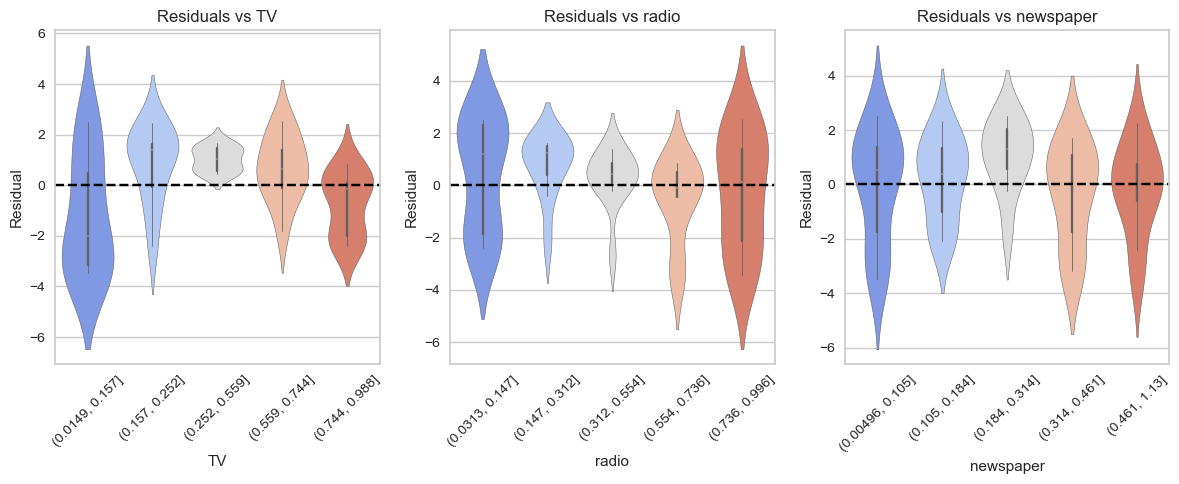

In [217]:
df_viz = X_test_scaled.copy()
df_viz['Residual'] = y_test.values - y_pred

plt.figure(figsize=(12,5))

for i, col in enumerate(['TV','radio','newspaper']):
    plt.subplot(1, 3, i+1)
    sns.violinplot(
        x=pd.qcut(df_viz[col], 5), 
        y=df_viz['Residual'], 
        hue=pd.qcut(df_viz[col], 5), 
        palette="coolwarm", 
        legend=False
    )
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"Residuals vs {col}")
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

Información similar a uno antes viusto muestra la densidad / distribución de los residuales en distrintos cortes de las diferentes variables, se aprecia lo anterior mencionado pero además en la variable de TV en el rango de [0.252, 0.559] que los residuales estan muy por encima de 0 en su mayoría

## Conclusión

En este ejercicio he podido comprobar que el modelo de regresión lineal aplicado sobre el dataset de Advertising es útil para ilustrar de manera sencilla cómo la inversión en distintos medios publicitarios (TV, radio y periódico) se relaciona con las ventas. Aunque los resultados muestran que la variable de TV es la que más peso tiene en la predicción y que el ajuste no es perfecto debido a la presencia de asimetrías y posibles problemas de normalidad en los residuos, considero que el valor principal de este análisis no está en construir el modelo “definitivo” para explicar las ventas, sino en demostrar de forma clara el procedimiento completo: desde la exploración de los datos, la construcción del modelo, hasta la evaluación de supuestos y pruebas estadísticas. De este modo, el potencial de este trabajo es pedagógico y práctico, ya que sirve como guía para comprender cómo se utilizan los modelos de regresión en contextos reales, y qué aspectos se deben revisar antes de confiar plenamente en sus resultados.